deeplabv3_resnet50 - base

In [23]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [24]:
import sys

folder_path = '/content/drive/MyDrive/Colab Notebooks/DLRN101021/'
sys.path.append(folder_path)

In [25]:
!pip install iterative-stratification
COLOR_TO_CLASS_NAME_MAP = {
    (255, 255, 255): "background",
    (1, 88, 255): "sky",
    (156, 76, 30): "rough trail",
    (178, 176, 153): "smooth trail",
    (128, 255, 0): "traversable grass",
    (40, 80, 0): "high vegetation",
    (0, 160, 0): "non-traversable low vegetation",
    (255, 0, 128): "puddle",
    (255, 0, 0): "obstacle",
}

CLASS_CODE_TO_CLASS_NAME_MAP = {
    4: "puddle",
    5: "obstacle",
    0: "background",
    6: "non-traversable low vegetation",
    8: "sky",
    2: "traversable grass",
    1: "smooth trail",
    3: "rough trail",
    7: "high vegetation",
}

In [26]:
# CONFIGURAZIONE
import torch.optim as optim
from torchvision import models
import torch
import numpy as np

NUM_CLASSES = 9
BATCH_SIZE = 4
NUM_EPOCHS = 15
EARLY_STOPPING_ITERATION_NUMBER = 15
DATASET_DIR = '/content/drive/MyDrive/training_sets/train/'
AUX_HEAD = True
BACKBONE_SPECIAL_TREATMENT = False
ALLOW_AUGMENTATION = True
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {DEVICE}")
if DEVICE.type == "cuda":
    print(f"GPU Name: {torch.cuda.get_device_name(DEVICE)}")

RARE_CLASSES = {4, 5, 6}    # classi sottorappresentate
DUPLICATE_FACTOR = 4        # quante volte duplicare i campioni rari

Using device: cuda
GPU Name: NVIDIA A100-SXM4-40GB


In [27]:
# DATASET CUSTOM
import os
import albumentations as A
import matplotlib.pyplot as plt


import torchvision.transforms.functional as TF

from PIL import Image
from torch.utils.data import Dataset, DataLoader
from albumentations.pytorch import ToTensorV2

from torchvision import transforms

class SegmentationDataset(Dataset):

    # Augmentazione per immagini con classi rare
    rare_aug = A.Compose([
        A.HorizontalFlip(p=0.5),
        A.RandomBrightnessContrast(p=0.4),
        #A.Rotate(limit=20, p=0.3), potenzialmente inutile
        A.Resize(256, 256),
        A.Normalize(mean=(0.485, 0.456, 0.406),
                    std=(0.229, 0.224, 0.225)),
        ToTensorV2()
    ])
    
    # Augmentazione mirata per immagini che contengono sia classi 1 che 3
    confused_aug = A.Compose([
        A.OneOf([
            A.MotionBlur(p=0.5),
            A.GaussianBlur(p=0.5),
            A.MedianBlur(blur_limit=5, p=0.5),
            A.GaussNoise(var_limit=(10.0, 50.0), p=0.5),
            A.Sharpen(p=0.5),
        ], p=1.0),
        A.RandomBrightnessContrast(p=0.3),
        A.Resize(256, 256),
        A.Normalize(mean=(0.485, 0.456, 0.406),
                    std=(0.229, 0.224, 0.225)),
        ToTensorV2()
    ])


    # Augmentazione di base
    base_aug = A.Compose([
        A.Resize(256, 256),
        A.Normalize(mean=(0.485, 0.456, 0.406),
                    std=(0.229, 0.224, 0.225)),
        ToTensorV2()
    ])

    def __init__(self, root_dir, is_val = False, sample_ids=None, allow_augmentation = False):
        self.samples = []
        self.is_val = is_val
        self.sample_ids = sample_ids
        self.allow_augmentation = allow_augmentation
        self._load_and_augment(root_dir)

    def _load_and_augment(self, root_dir):
        sample_dirs = []
        for id in self.sample_ids:
            sample_dirs.append(os.path.join(root_dir, id))

        for dir_path in sample_dirs:
            img_path = os.path.join(dir_path, 'rgb.jpg')
            label_path = os.path.join(dir_path, 'labels.png')

            label_img = Image.open(label_path)
            is_rare = SegmentationDataset.contains_rare_classes(label_img, RARE_CLASSES)

            if not self.allow_augmentation:
                is_rare = False

            # Sempre aggiungi l'originale
            self.samples.append((img_path, label_path, is_rare))

            # Duplicazione per oversampling (solo se contiene classi rare)
            if is_rare and not self.is_val:
                for _ in range(DUPLICATE_FACTOR - 1):
                    self.samples.append((img_path, label_path, is_rare))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label_path, is_rare = self.samples[idx]

        image = np.array(Image.open(img_path).convert("RGB"))
        label = np.array(Image.open(label_path)) # shape (H, W)

        if self.is_val:
            aug = SegmentationDataset.base_aug
        else:
            aug = SegmentationDataset.rare_aug if is_rare else SegmentationDataset.base_aug
        transformed = aug(image=image, mask=label)

        image_tensor = transformed['image']
        label_tensor = transformed['mask'].long()

        return image_tensor, label_tensor

    def getLoader(self, batch_size=4, shuffle=True, num_workers=2, drop_last=True):
        return DataLoader(self, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers, drop_last=drop_last)

    def show_sample(self, idx, normalized):
        """Visualizza la coppia immagine-label"""
        image, mask = self[idx]

        if not normalized:
            image = SegmentationDataset.denormalize(image.clone(), [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

        img_np = TF.to_pil_image(image)
        mask_np = mask.numpy()

        plt.figure(figsize=(12, 5))

        plt.subplot(1, 2, 1)
        plt.title("RGB image")
        plt.imshow(img_np)
        plt.axis("off")

        plt.subplot(1, 2, 2)
        plt.title("Label mask")
        plt.imshow(mask_np, cmap="tab10")
        plt.axis("off")

        plt.tight_layout()
        plt.show()

    @staticmethod
    def contains_rare_classes(label_img, rare_classes):
        label_np = np.array(label_img)
        unique = set(np.unique(label_np))
        return bool(rare_classes & unique)
    
    @staticmethod
    def contains_confused_classes(label_img):
        label_np = np.array(label_img)
        classes = set(np.unique(label_np))
        return (1 in classes) and (3 in classes)

    @staticmethod
    def denormalize(tensor, mean, std):
        """
        Inverte la normalizzazione per il tensore di un immagine (C, H, W).
        """
        for t, m, s in zip(tensor, mean, std):
            t.mul_(s).add_(m)
        return tensor


    @staticmethod
    def visualize_prediction(model, dataset, index, device):
        """
        Visualizza l'immagine di input, la ground trutg e le label predette dal dataset.
        """
        model.eval()
        sample = dataset[index]
        if isinstance(sample, dict):              # se è un dizionario
            image_tensor = sample['image']
            mask_tensor  = sample['mask']
        else:                                     # se è una tupla
            image_tensor, mask_tensor = sample
        image = image_tensor.unsqueeze(0).to(device)  # aggiunta batch size
        label = mask_tensor.squeeze().cpu().numpy()

        with torch.no_grad():
            output = model(image)['out']
            pred = torch.argmax(output.squeeze(), dim=0).cpu().numpy()

        # Conversione tensore to PIL image per la visualizzazione
        image_disp = transforms.ToPILImage()(image_tensor)

        # Plotting
        fig, axs = plt.subplots(1, 3, figsize=(15, 5))
        axs[0].imshow(image_disp)
        axs[0].set_title('Input Image')
        axs[1].imshow(label, cmap='tab20')
        axs[1].set_title('Ground Truth')
        axs[2].imshow(pred, cmap='tab20')
        axs[2].set_title('Predicted Mask')
        for ax in axs:
            ax.axis('off')
        plt.tight_layout()
        plt.show()


In [28]:
import numpy as np
from tqdm import tqdm
import torch.nn as nn

import torch.nn.functional as F
from torchvision.models.segmentation.deeplabv3 import ASPP

class CustomDeepLabHead(nn.Sequential):
    def __init__(self, in_channels, num_classes):
        super().__init__(
            ASPP(in_channels, [3, 7, 3]),  # ASPP con dilatazioni personalizzate
            # Primo layer convoluzionale: kernel 5x5
            nn.Conv2d(256, 256, kernel_size=5, padding=2),
            nn.ReLU(),
            # Secondo layer convoluzionale: kernel 5x5
            nn.Conv2d(256, 256, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.Dropout(0.05),
            nn.Conv2d(256, num_classes, kernel_size=1)      # output classi
        )


class Trainer:
    def __init__(self, model, train_loader, val_loader, device, json_log_path, criterion, optimizer, scheduler, use_aux=False, num_classes=9, lr=1e-4):
        self.model = model.to(device)
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.device = device
        self.num_classes = num_classes
        self.criterion = criterion
        self.optimizer = optimizer
        self.best_val_iou = 0.0
        self.best_val_validation_loss = float('inf')
        self.json_log_path = json_log_path
        self.scheduler = scheduler
        self.use_aux = use_aux

    def compute_iou(self, preds, labels):
        ious = []
        preds = preds.view(-1)
        labels = labels.view(-1)

        for cls in range(self.num_classes):
            pred_mask = preds == cls
            label_mask = labels == cls
            intersection = (pred_mask & label_mask).sum().item()
            union = (pred_mask | label_mask).sum().item()
            if union == 0:
                ious.append(float('nan'))  # classe non presente
            else:
                ious.append(intersection / union)

        return ious

    def train_one_epoch(self):
        self.model.train()
        total_loss = 0.0

        loop = tqdm(self.train_loader, desc="Training", leave=False)

        for images, masks in loop:
            images = images.to(self.device)
            masks = masks.to(self.device)

            self.optimizer.zero_grad()

            outputs = self.model(images)
            main_output = outputs["out"]

            loss = self.criterion(main_output, masks)

            if self.use_aux and "aux" in outputs:
                aux_output = outputs.get("aux") 
                aux_loss = self.criterion(aux_output, masks)
                loss += 0.4 * aux_loss

            loss.backward()
            self.optimizer.step()

            total_loss += loss.item()
            loop.set_postfix(loss=loss.item())

        return total_loss / len(self.train_loader)

    def validate(self):
        self.model.eval()
        total_loss = 0.0
        all_preds, all_masks = [], []

        loop = tqdm(self.val_loader, desc="Validation", leave=False)

        with torch.no_grad():
            for images, masks in loop:
                images = images.to(self.device)
                masks = masks.to(self.device)

                outputs = self.model(images)["out"]
                loss = self.criterion(outputs, masks)
                total_loss += loss.item()

                preds = torch.argmax(outputs, dim=1)
                all_preds.append(preds.cpu())
                all_masks.append(masks.cpu())

                loop.set_postfix(loss=loss.item())

        all_preds = torch.cat(all_preds)
        all_masks = torch.cat(all_masks)

        per_class_iou = self.compute_iou(all_preds, all_masks)

        return total_loss / len(self.val_loader), per_class_iou

    def save_fit_results(self):
        # Scrivi log su JSON
        with open(self.json_log_path, "w") as f:
            json.dump(self.history, f, indent=2)
        print(f"\n📝 Training log salvato in {self.json_log_path}")


    def fit(self, num_epochs=20, save_path="best_model.pth"):
        self.history = []
        epochs_with_no_improvements = 0

        for epoch in range(num_epochs):
            torch.cuda.reset_max_memory_allocated()
            print(f"\n🌱 Epoch {epoch+1}/{num_epochs}")

            if epochs_with_no_improvements > EARLY_STOPPING_ITERATION_NUMBER:
                print("Early stopping")
                continue

            train_loss = self.train_one_epoch()
            val_loss, val_ious = self.validate()
            val_ious_no_bg = val_ious[1:]
            mean_val_iou = np.nanmean(val_ious_no_bg)
            if self.scheduler:
                self.scheduler.step(val_loss)

            print(f"📊 Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Mean IoU: {mean_val_iou:.4f}")

            for i, iou in enumerate(val_ious):
                print(f"    ▸ IoU classe {i}: {iou:.4f}" if not np.isnan(iou) else f"    ▸ IoU classe {i}: N/A")

            # Salva lo stato dell'epoca
            max_gpu_ram_gb = torch.cuda.max_memory_allocated() / 1024 ** 3
            epoch_record = {
                "epoch": epoch + 1,
                "train_loss": train_loss,
                "val_loss": val_loss,
                "mean_iou": mean_val_iou,
                "ious_per_class": {str(i): (iou if not np.isnan(iou) else None) for i, iou in enumerate(val_ious)},
                "gpu_use": max_gpu_ram_gb
            }
            self.history.append(epoch_record)

            if mean_val_iou > self.best_val_iou:
                epochs_with_no_improvements = 0
                self.best_val_iou = mean_val_iou
                torch.save(self.model.state_dict(), "IoU_" + save_path)
                print(f"✅ New best IoU model saved to: IoU_{save_path}")
            else:
                epochs_with_no_improvements = epochs_with_no_improvements + 1

            if val_loss < self.best_val_validation_loss:
                self.best_val_validation_loss = val_loss
                torch.save(self.model.state_dict(), "validation_loss_" + save_path)
                print(f"✅ New best validation loss model saved to: validation_loss_{save_path}")

            print(f"🔝 Max GPU RAM usata quest'epoca: {max_gpu_ram_gb:.2f} GB")

        self.save_fit_results()

    @staticmethod
    def freeze_bn(model):
        # Congela completamente i BatchNorm
        for module in model.modules():
            if isinstance(module, nn.BatchNorm2d):
                module.eval()
                module.weight.requires_grad = False
                module.bias.requires_grad = False

    @staticmethod
    def freeze_bn_stats(model):
        # Congela solo le statistiche di BatchNorm
        for module in model.modules():
            if isinstance(module, nn.BatchNorm2d):
                module.eval()

    @staticmethod
    def freeze_full_backbone(model):
        # Congela completamente il backbone (feature extractor)
        for param in model.backbone.parameters():
            param.requires_grad = False

In [29]:
import random
import numpy as np
from PIL import Image
import os
from iterstrat.ml_stratifiers import MultilabelStratifiedShuffleSplit
import json

# sample male etichettati
excluded_dirs = {
    "0007", "0009", "0090", "0095", "0101", "0104", "0105",
    "0162", "0163", "0284", "0305", "0306", "0307", "0308", "0309", "0310", "0311",
    "0351", "0372", "0373", "0376",
    "0498", "0499", "0500", "0501", "0526", "0527", "0530", "0531", "0542",
    "0564", "0585", "0586", "0587", "0588", "0589", "0590",
    #seguono nuovo immagini da escludere
    "0000", "0001", "0052"
}

# Elenco di cartelle numeriche valide
all_dirs = sorted([
    d for d in os.listdir(DATASET_DIR)
    if os.path.isdir(os.path.join(DATASET_DIR, d)) and d.isdigit() and d not in excluded_dirs
])

#  COSTRUZIONE DELLA MATRICE MULTILABEL
def build_presence_matrix(dir_list, n_classes=9):
    """Restituisce un np.array (n_sample, n_classes) con booleani indicanti la presenza o meno della classe"""
    presence = np.zeros((len(dir_list), n_classes), dtype=int)

    for idx, d in enumerate(dir_list):
        label_path = os.path.join(DATASET_DIR, d, "labels.png")
        lbl = np.array(Image.open(label_path))
        uniq = np.unique(lbl)
        presence[idx, uniq] = 1          # segna le classi presenti
    return presence

Y = build_presence_matrix(all_dirs, NUM_CLASSES)

#  MULTILABEL STRATIFIED SPLIT
msss = MultilabelStratifiedShuffleSplit(n_splits=1, test_size=0.20, random_state=42)
train_idx, val_idx = next(msss.split(np.zeros(len(all_dirs)), Y))

train_ids = [all_dirs[i] for i in train_idx]
val_ids   = [all_dirs[i] for i in val_idx]

print("Campioni:", len(train_ids), "train |", len(val_ids), "val")

Campioni: 714 train | 177 val


In [30]:
# CARICAMENTO DATI
# Divisione training/validation
train_set = SegmentationDataset(DATASET_DIR, sample_ids=train_ids, allow_augmentation=ALLOW_AUGMENTATION)
val_set = SegmentationDataset(DATASET_DIR, sample_ids=val_ids, is_val=True, allow_augmentation=ALLOW_AUGMENTATION)

train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
val_loader = DataLoader(val_set, batch_size=BATCH_SIZE, drop_last=True)

In [31]:
# MODELLO
weights = models.segmentation.DeepLabV3_ResNet101_Weights.DEFAULT

model = models.segmentation.deeplabv3_resnet101(weights=weights)
# versione custom del classifier
model.classifier = CustomDeepLabHead(2048, NUM_CLASSES)

if AUX_HEAD:
    model.aux_classifier[-1] = nn.Conv2d(256, NUM_CLASSES, kernel_size=1)
else:
    model.aux_classifier = None

model.to(DEVICE)

# LOSS & OPTIMIZER
class_weights = torch.tensor([1.0, 1.0, 1.0, 1.0, 5.0, 4.0, 3.5, 0.8, 0.8]).to(DEVICE)
criterion = nn.CrossEntropyLoss(weight=class_weights)

if not BACKBONE_SPECIAL_TREATMENT:
    optimizer = optim.Adam(model.parameters(), lr=1e-4)
else:
    # per avere un learning più lento nella backbone
    backbone_params = list(model.backbone.parameters())
    head_params = list(model.classifier.parameters())
    optimizer = torch.optim.Adam([
        {'params': backbone_params, 'lr': 1e-5},   # pretrained: learning lento
        {'params': head_params,     'lr': 1e-4},   # new head: learning veloce
    ])

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=3
)

# TRAINING
trainer = Trainer(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    device=DEVICE,
    criterion=criterion,
    optimizer=optimizer,
    json_log_path="./training_log.json",
    scheduler=None,#scheduler,
    use_aux=AUX_HEAD
)

trainer.fit(num_epochs=NUM_EPOCHS)

/usr/local/lib/python3.11/dist-packages/torch/cuda/memory.py:391: FutureWarning: torch.cuda.reset_max_memory_allocated now calls torch.cuda.reset_peak_memory_stats, which resets /all/ peak memory stats.
  warnings.warn(



🌱 Epoch 1/15


📊 Train Loss: 0.8771 | Val Loss: 0.8204 | Mean IoU: 0.4197
    ▸ IoU classe 0: 0.4213
    ▸ IoU classe 1: 0.3845
    ▸ IoU classe 2: 0.3284
    ▸ IoU classe 3: 0.5354
    ▸ IoU classe 4: 0.0000
    ▸ IoU classe 5: 0.2322
    ▸ IoU classe 6: 0.2571
    ▸ IoU classe 7: 0.7605
    ▸ IoU classe 8: 0.8592
✅ New best IoU model saved to: best_model.pth
✅ New best validation loss model saved to: best_model.pth
🔝 Max GPU RAM usata quest'epoca: 3.61 GB

🌱 Epoch 2/15


📊 Train Loss: 0.6011 | Val Loss: 0.6838 | Mean IoU: 0.5736
    ▸ IoU classe 0: 0.4823
    ▸ IoU classe 1: 0.6775
    ▸ IoU classe 2: 0.5340
    ▸ IoU classe 3: 0.6065
    ▸ IoU classe 4: 0.4538
    ▸ IoU classe 5: 0.3009
    ▸ IoU classe 6: 0.3259
    ▸ IoU classe 7: 0.8079
    ▸ IoU classe 8: 0.8819
✅ New best IoU model saved to: best_model.pth
✅ New best validation loss model saved to: best_model.pth
🔝 Max GPU RAM usata quest'epoca: 2.69 GB

🌱 Epoch 3/15


📊 Train Loss: 0.4802 | Val Loss: 0.7415 | Mean IoU: 0.5809
    ▸ IoU classe 0: 0.5090
    ▸ IoU classe 1: 0.6385
    ▸ IoU classe 2: 0.5259
    ▸ IoU classe 3: 0.5921
    ▸ IoU classe 4: 0.5884
    ▸ IoU classe 5: 0.2981
    ▸ IoU classe 6: 0.3197
    ▸ IoU classe 7: 0.8170
    ▸ IoU classe 8: 0.8679
✅ New best IoU model saved to: best_model.pth
🔝 Max GPU RAM usata quest'epoca: 2.69 GB

🌱 Epoch 4/15


📊 Train Loss: 0.4041 | Val Loss: 0.7679 | Mean IoU: 0.5902
    ▸ IoU classe 0: 0.5187
    ▸ IoU classe 1: 0.6053
    ▸ IoU classe 2: 0.5026
    ▸ IoU classe 3: 0.5954
    ▸ IoU classe 4: 0.6463
    ▸ IoU classe 5: 0.3716
    ▸ IoU classe 6: 0.2877
    ▸ IoU classe 7: 0.8300
    ▸ IoU classe 8: 0.8824
✅ New best IoU model saved to: best_model.pth
🔝 Max GPU RAM usata quest'epoca: 2.69 GB

🌱 Epoch 5/15


📊 Train Loss: 0.3225 | Val Loss: 0.6668 | Mean IoU: 0.5737
    ▸ IoU classe 0: 0.5233
    ▸ IoU classe 1: 0.6630
    ▸ IoU classe 2: 0.4718
    ▸ IoU classe 3: 0.6129
    ▸ IoU classe 4: 0.4849
    ▸ IoU classe 5: 0.3621
    ▸ IoU classe 6: 0.2949
    ▸ IoU classe 7: 0.8166
    ▸ IoU classe 8: 0.8837
✅ New best validation loss model saved to: best_model.pth
🔝 Max GPU RAM usata quest'epoca: 2.69 GB

🌱 Epoch 6/15


📊 Train Loss: 0.2542 | Val Loss: 0.8593 | Mean IoU: 0.5960
    ▸ IoU classe 0: 0.5269
    ▸ IoU classe 1: 0.6218
    ▸ IoU classe 2: 0.5715
    ▸ IoU classe 3: 0.6012
    ▸ IoU classe 4: 0.5773
    ▸ IoU classe 5: 0.3786
    ▸ IoU classe 6: 0.2918
    ▸ IoU classe 7: 0.8336
    ▸ IoU classe 8: 0.8921
✅ New best IoU model saved to: best_model.pth
🔝 Max GPU RAM usata quest'epoca: 2.69 GB

🌱 Epoch 7/15


📊 Train Loss: 0.2179 | Val Loss: 0.9206 | Mean IoU: 0.6083
    ▸ IoU classe 0: 0.5299
    ▸ IoU classe 1: 0.6903
    ▸ IoU classe 2: 0.5554
    ▸ IoU classe 3: 0.6118
    ▸ IoU classe 4: 0.6142
    ▸ IoU classe 5: 0.4181
    ▸ IoU classe 6: 0.2802
    ▸ IoU classe 7: 0.8230
    ▸ IoU classe 8: 0.8730
✅ New best IoU model saved to: best_model.pth
🔝 Max GPU RAM usata quest'epoca: 2.69 GB

🌱 Epoch 8/15


📊 Train Loss: 0.2001 | Val Loss: 1.0314 | Mean IoU: 0.6104
    ▸ IoU classe 0: 0.5115
    ▸ IoU classe 1: 0.6314
    ▸ IoU classe 2: 0.5790
    ▸ IoU classe 3: 0.5813
    ▸ IoU classe 4: 0.7127
    ▸ IoU classe 5: 0.3847
    ▸ IoU classe 6: 0.2682
    ▸ IoU classe 7: 0.8420
    ▸ IoU classe 8: 0.8839
✅ New best IoU model saved to: best_model.pth
🔝 Max GPU RAM usata quest'epoca: 2.69 GB

🌱 Epoch 9/15


📊 Train Loss: 0.1828 | Val Loss: 1.0295 | Mean IoU: 0.6036
    ▸ IoU classe 0: 0.5125
    ▸ IoU classe 1: 0.6292
    ▸ IoU classe 2: 0.6008
    ▸ IoU classe 3: 0.6154
    ▸ IoU classe 4: 0.4687
    ▸ IoU classe 5: 0.4999
    ▸ IoU classe 6: 0.2920
    ▸ IoU classe 7: 0.8358
    ▸ IoU classe 8: 0.8873
🔝 Max GPU RAM usata quest'epoca: 2.69 GB

🌱 Epoch 10/15


📊 Train Loss: 0.2118 | Val Loss: 0.9152 | Mean IoU: 0.5564
    ▸ IoU classe 0: 0.5322
    ▸ IoU classe 1: 0.6542
    ▸ IoU classe 2: 0.5346
    ▸ IoU classe 3: 0.5788
    ▸ IoU classe 4: 0.4592
    ▸ IoU classe 5: 0.2600
    ▸ IoU classe 6: 0.2783
    ▸ IoU classe 7: 0.8159
    ▸ IoU classe 8: 0.8700
🔝 Max GPU RAM usata quest'epoca: 2.69 GB

🌱 Epoch 11/15


📊 Train Loss: 0.1694 | Val Loss: 0.8965 | Mean IoU: 0.6278
    ▸ IoU classe 0: 0.5405
    ▸ IoU classe 1: 0.6805
    ▸ IoU classe 2: 0.5821
    ▸ IoU classe 3: 0.6288
    ▸ IoU classe 4: 0.5664
    ▸ IoU classe 5: 0.5134
    ▸ IoU classe 6: 0.3329
    ▸ IoU classe 7: 0.8258
    ▸ IoU classe 8: 0.8929
✅ New best IoU model saved to: best_model.pth
🔝 Max GPU RAM usata quest'epoca: 2.69 GB

🌱 Epoch 12/15


📊 Train Loss: 0.1603 | Val Loss: 1.0165 | Mean IoU: 0.6231
    ▸ IoU classe 0: 0.5154
    ▸ IoU classe 1: 0.6884
    ▸ IoU classe 2: 0.5859
    ▸ IoU classe 3: 0.6236
    ▸ IoU classe 4: 0.6705
    ▸ IoU classe 5: 0.4107
    ▸ IoU classe 6: 0.3054
    ▸ IoU classe 7: 0.8273
    ▸ IoU classe 8: 0.8727
🔝 Max GPU RAM usata quest'epoca: 2.69 GB

🌱 Epoch 13/15


📊 Train Loss: 0.1304 | Val Loss: 1.1657 | Mean IoU: 0.6021
    ▸ IoU classe 0: 0.5322
    ▸ IoU classe 1: 0.6665
    ▸ IoU classe 2: 0.5983
    ▸ IoU classe 3: 0.6138
    ▸ IoU classe 4: 0.4991
    ▸ IoU classe 5: 0.4405
    ▸ IoU classe 6: 0.2794
    ▸ IoU classe 7: 0.8372
    ▸ IoU classe 8: 0.8819
🔝 Max GPU RAM usata quest'epoca: 2.69 GB

🌱 Epoch 14/15


📊 Train Loss: 0.1128 | Val Loss: 1.2593 | Mean IoU: 0.5939
    ▸ IoU classe 0: 0.5441
    ▸ IoU classe 1: 0.6289
    ▸ IoU classe 2: 0.5834
    ▸ IoU classe 3: 0.5982
    ▸ IoU classe 4: 0.4237
    ▸ IoU classe 5: 0.5087
    ▸ IoU classe 6: 0.2770
    ▸ IoU classe 7: 0.8353
    ▸ IoU classe 8: 0.8963
🔝 Max GPU RAM usata quest'epoca: 2.69 GB

🌱 Epoch 15/15


📊 Train Loss: 0.0967 | Val Loss: 1.3038 | Mean IoU: 0.6037
    ▸ IoU classe 0: 0.5218
    ▸ IoU classe 1: 0.6561
    ▸ IoU classe 2: 0.5922
    ▸ IoU classe 3: 0.6097
    ▸ IoU classe 4: 0.4763
    ▸ IoU classe 5: 0.5109
    ▸ IoU classe 6: 0.2565
    ▸ IoU classe 7: 0.8345
    ▸ IoU classe 8: 0.8934
🔝 Max GPU RAM usata quest'epoca: 2.69 GB

📝 Training log salvato in ./training_log.json


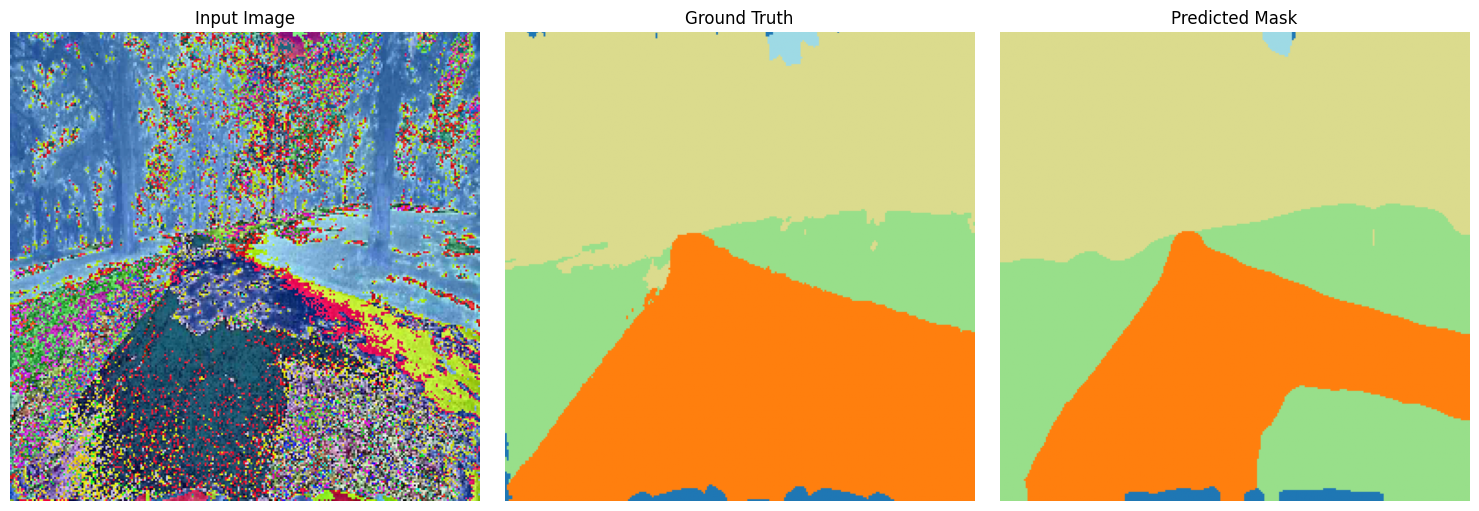

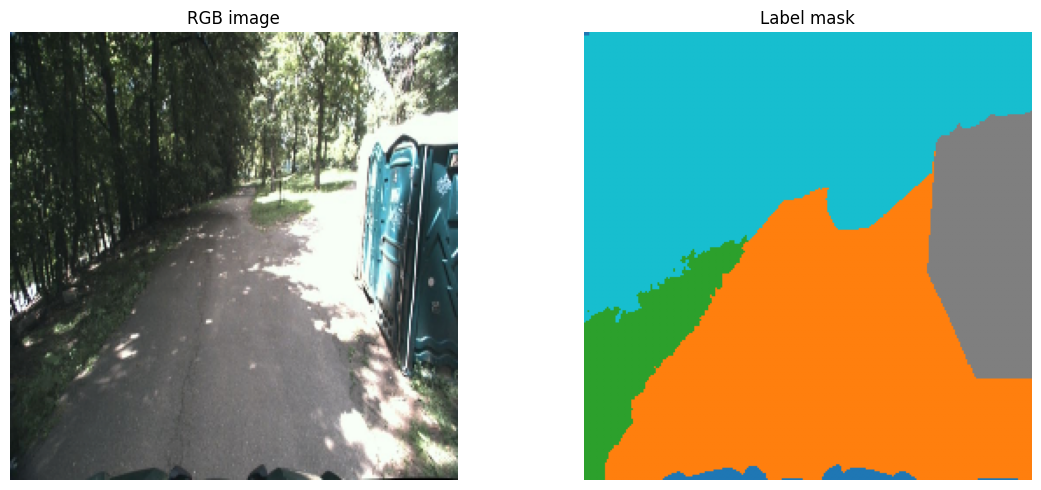

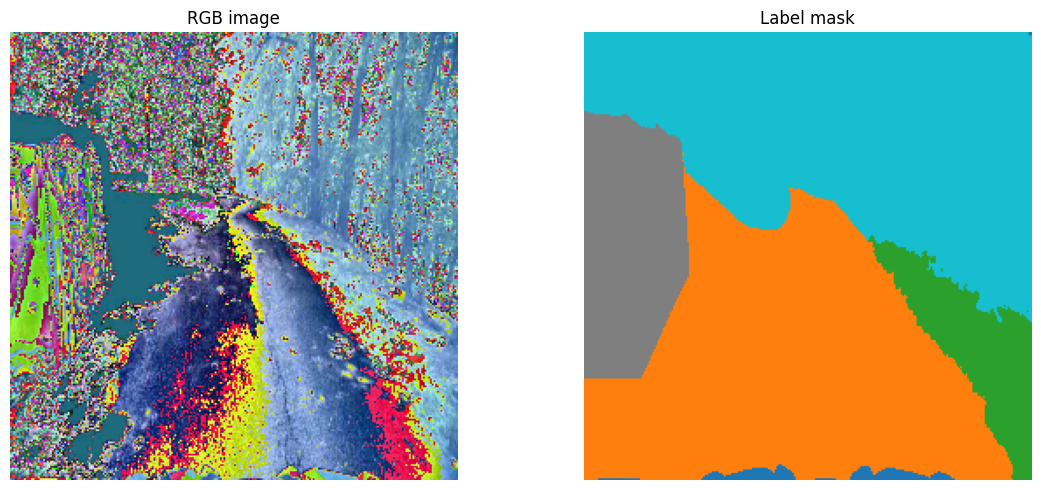

In [32]:
# Visualizza la predizione su un'immagine del validation set
index_to_visualize = 0  # oppure un altro indice valido nel validation set
SegmentationDataset.visualize_prediction(model, val_set, index_to_visualize, DEVICE)
train_set.show_sample(0, False)
train_set.show_sample(0, True)

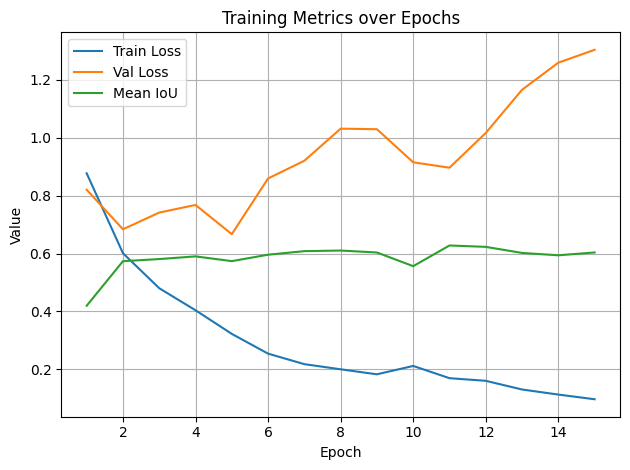

In [33]:
import json

# Carica dati da file
with open('./training_log.json', 'r') as f:
    data = json.load(f)

# Estrazione metriche
epochs = [d["epoch"] for d in data]
train_loss = [d["train_loss"] for d in data]
val_loss = [d["val_loss"] for d in data]
mean_iou = [d["mean_iou"] for d in data]

# Plot
plt.plot(epochs, train_loss, label="Train Loss")
plt.plot(epochs, val_loss, label="Val Loss")
plt.plot(epochs, mean_iou, label="Mean IoU")
plt.xlabel("Epoch")
plt.ylabel("Value")
plt.title("Training Metrics over Epochs")
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.savefig("training_metrics.png", dpi=300)

plt.show()

In [33]:
# Salvataggio split nel caso si voglia riutilizzare
val_ids_clean = [os.path.basename(path) for path in val_ids]

with open("val_ids.json", "w") as f:
    json.dump(val_ids_clean, f, indent=4)